In [1]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.linear_model import LinearRegression, Ridge
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import iplot, init_notebook_mode
from plotly import graph_objs as go
init_notebook_mode(True)

seed = 5000 # for the results which involve randomness
import random
random.seed(seed)

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', \
                'model_year', 'origin', 'car_name']
df = pd.read_csv('auto-mpg.csv', delim_whitespace=True, names=column_names)

In [4]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Check for missing values in _horsepower_ column

In [5]:
horsepower_missing_idx = df[df.horsepower=='?'].index
df.loc[horsepower_missing_idx]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


In [6]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

Missing values in _horsepower_ will be replaced by the mean value of the column

In [7]:
df.loc[horsepower_missing_idx, 'horsepower'] = float('nan')
df.horsepower = df.horsepower.apply(pd.to_numeric)
df.loc[horsepower_missing_idx, 'horsepower'] = int( df.horsepower.mean() )

Display summary of the features

In [8]:
pd.set_option('precision', 2)
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.00,398.00,398.00,398.00,398.00,398.00,398.00,398.00
mean,23.51,5.45,193.43,104.46,2970.42,15.57,76.01,1.57
std,7.82,1.70,104.27,38.20,846.84,2.76,3.70,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.50,4.00,104.25,76.00,2223.75,13.83,73.00,1.00
50%,23.00,4.00,148.50,95.00,2803.50,15.50,76.00,1.00
75%,29.00,8.00,262.00,125.00,3608.00,17.17,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


Split dataset into 260 instances for training, 58 instances for cross-validation and the remaining 80 instances for testing

In [9]:
train, val, test = np.split(df.sample(frac=1), [260, 318])

In [10]:
feature_list = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']
target = ['mpg']

# Bi-variate analysis

Perform bivariate analysis to check for trends across features

In [11]:
plt.rcParams["figure.figsize"] = (18, 12)

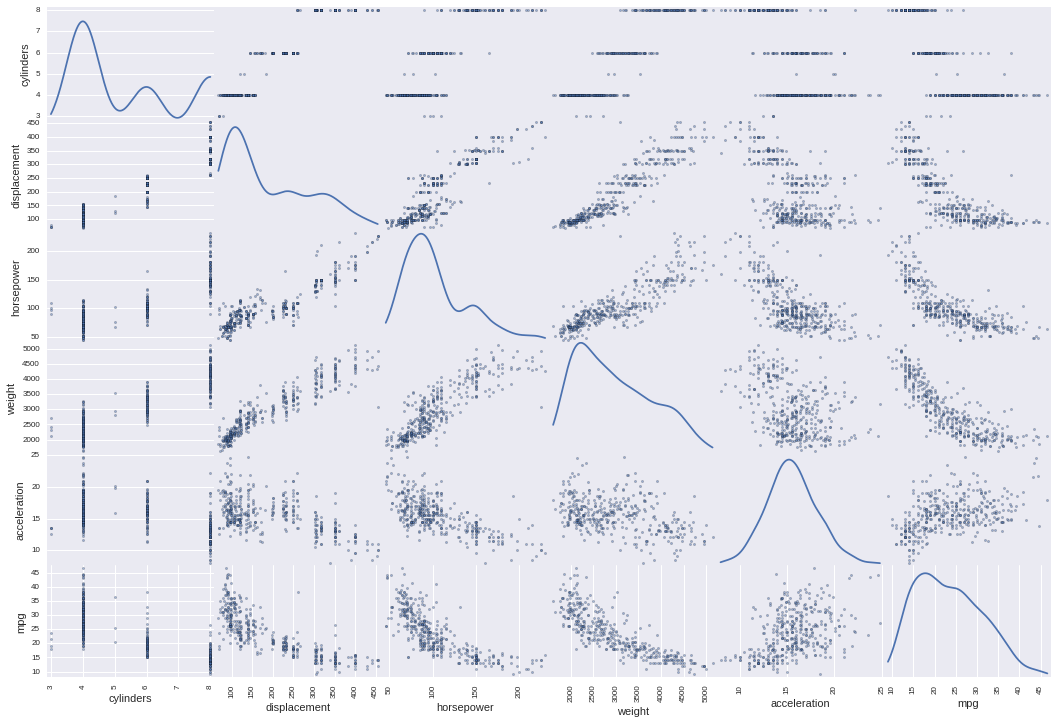

In [12]:
pd.tools.plotting.scatter_matrix(df.loc[:, feature_list+target], diagonal="kde")
plt.show()

#### Insights:
1. Based on the above plots, we can say that **mpg** is a strong function of **displacement, horsepower & weight**. Based on these insights, I'll experiment with models based on different input features
2. The above graphs also suggest that relation between mpg & displacement, horsepower & weight could be of **polynomial function**
3. The features displacement, horsepower & weight run high risk of being **autocorrelated** to each other, thus violating one of the assumptions of regression

# OLS with different sets of features¶

I will test the regression models with different set of features. Initially, I'll add those features with high correlation & check for change in MSE. Later, I'll add features with low correlation & monitor the MSE value. According to my hypothesis, features like acceleration & cylinders with low correlation will increase MSE value

In [13]:
ols_1_features = ['weight']
ols_2_features = ols_1_features + ['horsepower']
ols_3_features = ols_2_features + ['displacement']
ols_4_features = ols_3_features + ['acceleration']

In [14]:
# Create regression object
ols_1 = LinearRegression(normalize=True)
ols_2 = LinearRegression(normalize=True)
ols_3 = LinearRegression(normalize=True)
ols_4 = LinearRegression(normalize=True)

In [15]:
# Fit models on train data
ols_1.fit(train[ols_1_features], train[target])
ols_2.fit(train[ols_2_features], train[target])
ols_3.fit(train[ols_3_features], train[target])
ols_4.fit(train[ols_4_features], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [16]:
print "MSE for ols_1 on validation set: {:.2f}".format(mean_squared_error(val[target], \
                                                                          ols_1.predict(val[ols_1_features])))
print "MSE for ols_2 on validation set: {:.2f}".format(mean_squared_error(val[target], \
                                                                          ols_2.predict(val[ols_2_features])))
print "MSE for ols_3 on validation set: {:.2f}".format(mean_squared_error(val[target], \
                                                                          ols_3.predict(val[ols_3_features])))
print "MSE for ols_4 on validation set: {:.2f}".format(mean_squared_error(val[target], \
                                                                          ols_4.predict(val[ols_4_features])))
mse_val_ols = mean_squared_error(val[target], ols_3.predict(val[ols_3_features]))
mse_test_ols = mean_squared_error(test[target], ols_3.predict(test[ols_3_features]))

MSE for ols_1 on validation set: 17.06
MSE for ols_2 on validation set: 15.77
MSE for ols_3 on validation set: 15.97
MSE for ols_4 on validation set: 15.96


As we can infer from the error values, for our linear model, adding acceleration & cylinders will increase the error value due to absence of any correlation with mpg.
<br>
Thus, for OLS, we get the best possible model with the feature list of **weight, horsepower & displacement**

***Next, I'll try to reduce the error term. Since the bivariate plots strongly show quadratic relation between the feature list & mpg, I'll introduce polynomial features and fit using OLS***

# Polynomial regression

In [17]:
# Create polynomial features
poly = PolynomialFeatures(2, include_bias=False)
train_poly = poly.fit_transform(train[ols_3_features])
val_poly = poly.fit_transform(val[ols_3_features])
test_poly = poly.fit_transform(test[ols_3_features])

In [18]:
# Print names of the new polynomial features created
poly.get_feature_names(ols_3_features)

['weight',
 'horsepower',
 'displacement',
 'weight^2',
 'weight horsepower',
 'weight displacement',
 'horsepower^2',
 'horsepower displacement',
 'displacement^2']

In [19]:
polyReg_1 = LinearRegression(normalize=True)
polyReg_1.fit(train_poly, train[target])
mse_val_poly = mean_squared_error(val[target], polyReg_1.predict(val_poly))
mse_test_poly = mean_squared_error(test[target], polyReg_1.predict(test_poly))
print "MSE for polynomial regression on validation dataset is: {:f}".format(mse_val_poly)

MSE for polynomial regression on validation dataset is: 14.123720


**Analysis:** 
<br>
***Reduction of value 3 in MSE!***
Next, I'll try to reduce overfitting by fitting these polynomial features through ridge regression 
<br>
Since we are using polynomial features, it becomes important to check for overfitting. One way to do so is by using Ridge regression which limits the influence of any individual feature

# Ridge regression for polynomial features

Ridge regression tries to prevent overfitting of models by limiting the value of weights using l2 penalty. Optimal value of l2 penalty is arrived at by searching between 1e-12 and 1e5

In [20]:
def ridge_validation_error(l2_penalty, train_data, val_data, train_target, val_target):
    
#     X = train_data[feature_list]
#     y = train_data[target]
    model = Ridge(alpha=l2_penalty, normalize=True)
    model.fit(train_data, train_target)
    
    # Compute the validation error on validation set
    
#     predictions = model.predict(val_data[feature_list])
    error = mean_squared_error(val_target, model.predict(val_data))
    
    return error

In [21]:
min_error = float('inf')
allErrors = [] # for plotting purposes


# iterate over different L2 values for ridge regression
for l2_penalty in np.logspace(-10, 5, 13):
    error = ridge_validation_error(l2_penalty, train_poly, val_poly, train[target], val[target])
    allErrors.append(error)
    if error < min_error: 
        min_error = error
        optimal_l2_penalty = l2_penalty
mse_val_ridge = min_error
print 'On cross-validation, ridge regression with a L2 penalty of {:g} was observed to \
get the minimum possible \nMSE of {:f}'.format(optimal_l2_penalty, mse_val_ridge)

# save test mse
model = Ridge(alpha=optimal_l2_penalty, normalize=True)
model.fit(train_poly, train[target])
mse_test_ridge = mean_squared_error(test[target], model.predict(test_poly))

On cross-validation, ridge regression with a L2 penalty of 0.00316228 was observed to get the minimum possible 
MSE of 13.711602


Plot prediction accuracy achieved by the parameter combinations tried

In [22]:
plt.rcParams["figure.figsize"] = (6, 4)

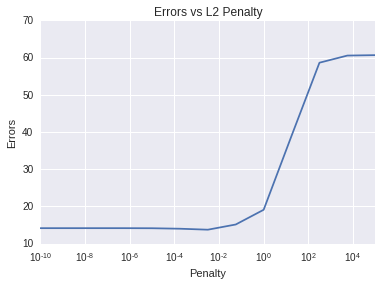

In [23]:
# Plot the different l2_penalty values tried in the x axis and the validation error in the y axis.
plt.figure()
plt.plot(np.logspace(-10, 5, 13), allErrors, '-')
plt.title("Errors vs L2 Penalty")
plt.xlabel("Penalty")
plt.ylabel("Errors")
plt.xscale('log')
plt.show()

**Analysis:** Ridge regression didn't lead to any noticeable improvement in loss term. This indicates that our model is not overfitting

# Decision tree

In [24]:
def decisionTree_val_error(train_data, val_data, train_target, val_target, max_depth):
    dtRegressor = tree.DecisionTreeRegressor(random_state=seed, max_depth = max_depth)
    dtRegressor = dtRegressor.fit(train_data, train_target)
    error = mean_squared_error(val[target], dtRegressor.predict(val_data))
    
    return error

In [25]:
min_error = float('inf')
allErrors = [] # for plotting purposes

# iterate over different depth values of decision tree
for max_depth in range(2,20):
    error = decisionTree_val_error(train[ols_3_features], val[ols_3_features], \
                                   train[target], val[target], max_depth)
    allErrors.append(error)
    if error < min_error: 
        min_error = error
        optimal_max_depth = max_depth
print 'On cross-validation, decision tree with a depth of {} was observed to \
get the minimum possible mean squared error of {:.2f}'.format(optimal_max_depth, min_error)
mse_val_dt = min_error

On cross-validation, decision tree with a depth of 6 was observed to get the minimum possible mean squared error of 15.78


In [26]:
# Store test MSE
model = tree.DecisionTreeRegressor(random_state=seed, max_depth = optimal_max_depth)
model.fit(train[ols_3_features], train[target])
mse_test_dt = mean_squared_error(test[target], model.predict(test[ols_3_features])) 

Plot prediction accuracy achieved by the parameter combinations tried

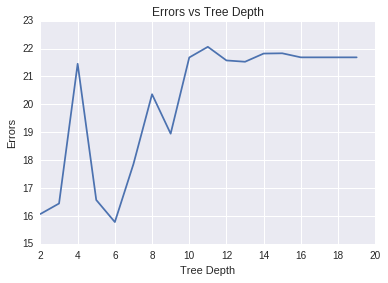

In [27]:
# Plot the different tree depth values tried in the x axis and the validation error in the y axis.
plt.figure()
plt.plot(range(2,20), allErrors, '-')
plt.title("Errors vs Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Errors")
plt.show()

# Random forest

In [28]:
def rf_val_error(train_data, val_data, train_target, val_target, n_estimators):
    
    rfRegressor = RandomForestRegressor(random_state=seed, n_estimators = n_estimators)
    rfRegressor = rfRegressor.fit(train_data, train_target)
    error = mean_squared_error(val[target], rfRegressor.predict(val_data))
    
    return error

In [29]:
min_error = float('inf')
allErrors = [] # for plotting purposes

# iterate over different number of trees in random forest
for n_tree in range(5,50,5):
    error = rf_val_error(train[ols_3_features], val[ols_3_features], train[target], val[target], n_tree)
    allErrors.append(error)
    if error < min_error: 
        min_error = error
        optimal_n_tree = n_tree
print 'On cross-validation, random forest with {} trees was observed to \
get the minimum possible mean squared error of {:.2f}'.format(optimal_n_tree, min_error)
mse_val_rf = min_error

On cross-validation, random forest with 10 trees was observed to get the minimum possible mean squared error of 13.68


In [30]:
# Store test mse
final_rf_model = RandomForestRegressor(random_state=seed, n_estimators = optimal_n_tree)
final_rf_model.fit(train[ols_3_features], train[target])
mse_test_rf = mean_squared_error(test[target], final_rf_model.predict(test[ols_3_features]))

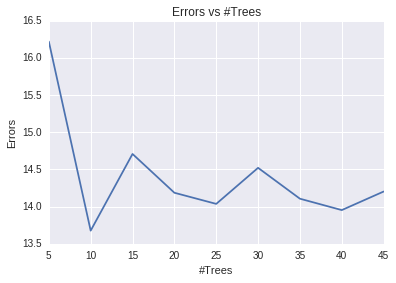

In [31]:
# Plot the different number of trees tried in the x axis and the validation error in the y axis.
plt.figure()
plt.plot(range(5,50,5), allErrors, '-')
plt.title("Errors vs #Trees")
plt.xlabel("#Trees")
plt.ylabel("Errors")
plt.show()

**Analysis:** All the trees trained in random forests are independent of each other. An ensemble of trees is trained using bootstrapp sampled data. Thus we see an improvement in accuracy over Decision Tree

# Gradient Boosting

In [32]:
def gbm_val_error(train_data, val_data, train_target, val_target, n_estimators):
    
    gbmRegressor = GradientBoostingRegressor(random_state=seed, n_estimators = n_estimators)
    gbmRegressor = gbmRegressor.fit(train_data, train_target)
    error = mean_squared_error(val[target], gbmRegressor.predict(val_data))
    
    return error

In [33]:
min_error = float('inf')
allErrors = [] # for plotting purposes

# iterate over different number of trees in random forest
for n_estimators in range(5,70,5):
    error = gbm_val_error(train[ols_3_features], val[ols_3_features], train[target], val[target], n_estimators)
    allErrors.append(error)
    if error < min_error: 
        min_error = error
        optimal_n_estimators = n_estimators
print 'On cross-validation, GBM with {} sequential trees was observed to \
get the minimum possible mean squared error \nof {:.2f}'.format(optimal_n_estimators, min_error)
mse_val_gbm = min_error

On cross-validation, GBM with 55 sequential trees was observed to get the minimum possible mean squared error 
of 13.19


In [34]:
# Store test mse
final_gbm_model = GradientBoostingRegressor(random_state=seed, n_estimators = 45)
final_gbm_model = final_gbm_model.fit(train[ols_3_features], train[target])
mse_test_gbm = mean_squared_error(test[target], final_gbm_model.predict(test[ols_3_features]))

Plot prediction accuracy achieved by the parameter combinations tried

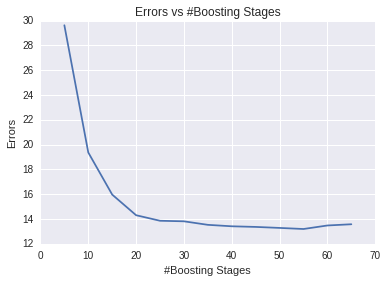

In [35]:
# Plot the different number of boosting stages tried in the x axis and the validation error in the y axis.
plt.figure()
plt.plot(range(5,70,5), allErrors, '-')
plt.title("Errors vs #Boosting Stages")
plt.xlabel("#Boosting Stages")
plt.ylabel("Errors")
plt.show()

**Analysis:** Consequent tree is trained so as to reduce the error of the previous tree. But in Random Forest, all the trees are independent. Thus GBM increases the accuracy of our model

**Using Random forest & GBM, lower mean squared error was achieved. An ensemble of both these methods can be used as the final solution**

### Generating validation & test predictions for ensemble model

In [36]:
# Generate predictions
val_pred_ensemble = np.mean([final_rf_model.predict(val[ols_3_features]), \
                            final_gbm_model.predict(val[ols_3_features])], axis=0)
test_pred_ensemble = np.mean([final_rf_model.predict(test[ols_3_features]), \
                            final_gbm_model.predict(test[ols_3_features])], axis=0)

# Calculate MSE
mse_val_ensemble = mean_squared_error(val[target], val_pred_ensemble)
mse_test_ensemble = mean_squared_error(test[target], test_pred_ensemble)

# Conclusion

## MSE on Validation dataset

### Overall performance plot on validation dataset

In [37]:
mse_val = pd.DataFrame({'Algo': ['OLS', 'Poly', 'Ridge', 'Decision Tree', 'RF', 'GBM', 'RF_GBM'],\
                            'Score':[mse_val_ols, mse_val_poly, mse_val_ridge, mse_val_dt, \
                                     mse_val_rf, mse_val_gbm, mse_val_ensemble], \
                            'Metric':'Validation MSE'})
mse_val.Score = mse_val.Score.apply(lambda x: round(x,4))

mse_val_data = []
for algo in mse_val.Algo.unique():
    temp1 = go.Bar(
    x = mse_val.Metric.unique().tolist(),
    y = mse_val[mse_val.Algo==algo].Score.tolist(),
    name= algo
    )
    mse_val_data.append(temp1)
    
iplot({
        'data':mse_val_data
        ,'layout':go.Layout(
                title='Regression Algorithms Performance on Validation set- MSE'
                ,xaxis={'title': 'Algorithms'}
                ,yaxis={'title': 'Metric Score'} 
        )
    })

## MSE on Test dataset

### Overall performance plot on test dataset

In [38]:
mse_test = pd.DataFrame({'Algo': ['OLS', 'Poly', 'Ridge', 'Decision Tree', 'RF', 'GBM', 'RF_GBM'],\
                            'Score':[mse_test_ols, mse_test_poly, mse_test_ridge, mse_test_dt, \
                                     mse_test_rf, mse_test_gbm, mse_test_ensemble], \
                            'Metric':'Test MSE'})
mse_test.Score = mse_test.Score.apply(lambda x: round(x,4))

mse_test_data = []
for algo in mse_val.Algo.unique():
    temp2 = go.Bar(
    x = mse_test.Metric.unique().tolist(),
    y = mse_test[mse_test.Algo==algo].Score.tolist(),
    name= algo
    )
    mse_test_data.append(temp2)
    
iplot({
        'data':mse_test_data
        ,'layout':go.Layout(
                title='Regression Algorithms Performance on Test set- MSE'
                ,xaxis={'title': 'Algorithms'}
                ,yaxis={'title': 'Metric Score'} 
        )
    })